In [1]:
import yaml
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import argparse
import pickle

R_LHC = 2760*11.246

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
R_LHC

31038.960000000003

In [ ]:
def calc_roc_2pred(preds, labels):
    
    assert np.shape(preds)[0] == 2
    
    threshes = list(np.linspace(0,1,50000))
    tpr = []
    fpr = []
    
    for thresh in tqdm(threshes):
        y = np.where(preds>thresh, 1, 0)
        y = np.logical_or(y[0],y[1])*1
        
        num_pos = np.sum(labels==1)
        num_neg = np.sum(labels==0)

        tpr.append( np.sum( np.logical_and(y==1,labels==1 ))/num_pos )
        fpr.append( np.sum( np.logical_and(y==1,labels==0 ))/num_neg )
    
    tpr.reverse()
    fpr.reverse()
    threshes.reverse()
    
    auc = 0.
    for i in range(len(tpr)-1):
        interval = fpr[i+1]-fpr[i]
        f = np.mean([tpr[i+1],tpr[i]])
        
        auc += interval*f
        
    return np.array(tpr), np.array(fpr), np.array(threshes), auc

def get_idx_for_interested_tpr(fprs, max_fpr):
    
    for i, fpr in enumerate(fprs):
        if fpr > max_fpr:
            return i-1
    
def plot_trig_roc(tpr, fpr, auc, tpr_factor=1, fpr_factor=1, total_signal=1008832, TDR=False, title=''):
    
    if not(TDR):
        tpr = tpr*(tpr_factor*0.547795576554444*total_signal)
    else:
        tpr = tpr*(tpr_factor*0.127986643476027*total_signal)
    
    R_LHC = 2760*11.246*fpr_factor
    
    colors = ['red', 'orange', 'green', 'blue', 'purple', 'black', 'red', 'orange', 'green']

    fig, ax = plt.subplots()
    
    ax.semilogy(fpr*R_LHC,tpr, label=f'AUROC: {auc:.4f}')
    
    for i, rate in enumerate([10, 30, 60, 77, 100, 150, 200, 500]):
        idx = get_idx_for_interested_tpr(fpr*R_LHC, rate)
        ax.axvline(x=rate, label=f'{rate}: {tpr[idx]:.0f}', linestyle='dashed', c=colors[i])
    
    ax.set_xlim((0,600))
    max_tpr = max(tpr)
    ax.set_ylim((0,max_tpr))
    
    secax = ax.secondary_yaxis('right', functions=((lambda x:x/max_tpr), lambda x:x))
    secax.set_ylabel('Trigger Efficiency')
    ax.grid()
    ax.legend(title='Rate (kHz): Yield (Events)')
    ax.set_xlabel('Trigger Rate (kHz)')
    ax.set_ylabel(f'Trigger Yield (Accepted Events)')
    ax.set_title(title)
    plt.show()
    
def hit_filter(event):
    return (event['mu_hit_type']!=0)*(event['mu_hit_neighbor']==0)

def filtered_row(row):
    copy = row
    
    mask = hit_filter(row)
    
    for key in copy.keys():
        if 'mu_hit' in key and key != 'n_mu_hit' and key != 'mu_hit_dR':
            copy[key] = copy[key][mask]
        elif key == 'n_mu_hit':
            copy[key] = sum(mask)
            
    return copy

In [4]:
pos_log_name = ''
with open(pos_log_name+'/valid_test_predictions.pkl', 'rb') as handle:
    pos_pred_dict = pickle.load(handle)
    
neg_log_name  = ''
with open(neg_log_name+'/valid_test_predictions.pkl', 'rb') as handle:
    neg_pred_dict = pickle.load(handle)

In [9]:
concat_dataset_path = ''

with open(concat_dataset_path, 'rb') as handle:
    df = pickle.load(handle)

df = df[df['n_mu_hit']>0]
df = df.apply(filtered_row, axis=1)

100%|████████████████████████████████████| 10000/10000 [00:32<00:00, 307.50it/s]
/tmp/ipykernel_175387/3987091650.py:59: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim((0,max_tpr))


1.0
1.0


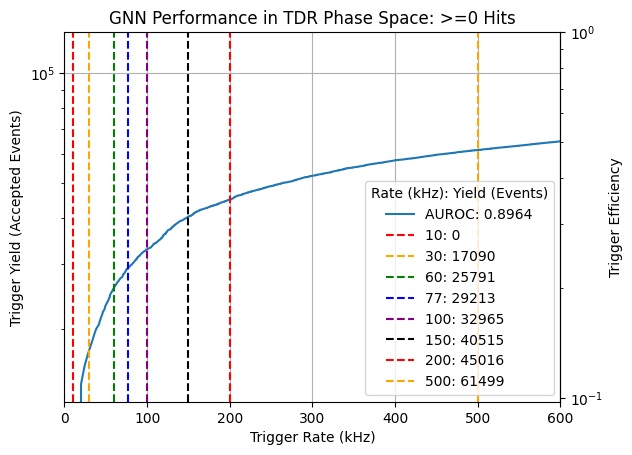

In [12]:
tpr_factors = []
fpr_factors = []
hit_threshes = []

for hit_thresh in hit_threshes:

    idxs = list(pos_pred_dict.keys()) + list(neg_pred_dict.keys())
    idxs = np.array(idxs)
    idxs = np.unique(idxs)
    
    num_signal_total = 0
    num_signal = 0
    num_bkg_total = 0
    num_bkg = 0

    preds = [[],[]]
    all_labels = []
    labels = []

    mixed_idxs = []


    for i, idx in tqdm(enumerate(idxs),total=len(idxs)):
        try:
            event = df.iloc[idx]
        except:
            continue
                
        if idx in pos_pred_dict.keys() and idx in neg_pred_dict.keys():
            
            num_hits_pos = np.sum(event['mu_hit_endcap']==1)
            num_hits_neg = np.sum(event['mu_hit_endcap']==-1)
        
            if event['n_gen_tau'] == 1:
                num_signal_total += 1
            else:
                num_bkg_total += 1
            
            if num_hits_pos + num_hits_neg < hit_thresh:
                continue
                
            pos_pred = pos_pred_dict[idx][0]
            pos_label = pos_pred_dict[idx][1]
            neg_pred = neg_pred_dict[idx][0]
            neg_label = neg_pred_dict[idx][1]
            
            if event['n_gen_tau'] == 1:
                num_signal += 1
            else:
                num_bkg += 1
            
            preds[0].append(pos_pred)
            preds[1].append(neg_pred)
            labels.append(max([pos_label, neg_label]))
            mixed_idxs.append(i)

    preds = np.array(preds)
    labels = np.array(labels)
    all_labels = np.array(all_labels)
    mixed_idxs = np.array(mixed_idxs)
    
    tpr, fpr, threshes, auc = calc_roc_2pred(preds, labels)
    
    tpr_factor = num_signal/num_signal_total
    fpr_factor = num_bkg/num_bkg_total
    tpr_factors.append(tpr_factor)
    fpr_factors.append(fpr_factor)
    print(tpr_factor)
    print(fpr_factor)
    
    plot_trig_roc(tpr, fpr, auc, tpr_factor=tpr_factor, fpr_factor=fpr_factor, TDR=False, title=f'GNN Performance in Loose Phase Space: >={hit_thresh} Hits')

In [ ]:
num_hits = [[],[]]
idxs = list(pos_pred_dict.keys()) + list(neg_pred_dict.keys())

signal_hits = [[],[]]
bkg_hits = [[],[]]

idxs = np.array(idxs)
idxs = np.unique(idxs)
    
for i, idx in tqdm(enumerate(idxs),total=len(idxs)):
    try:
        event = df.iloc[idx]
    except:
        continue
    
    num_hits_pos = np.sum(event['mu_hit_endcap']==1)
    num_hits_neg = np.sum(event['mu_hit_endcap']==-1)
    
    if event['n_gen_mu'] == 3:
        num_hits[0].append(event['n_mu_hit'])
        
        if event['gen_tau_eta'][0] > 0:
        
            signal_hits[0].append(num_hits_pos)
            signal_hits[1].append(num_hits_neg)
        
    else:
        num_hits[1].append(event['n_mu_hit'])
        bkg_hits[0].append(num_hits_pos)
        bkg_hits[1].append(num_hits_neg)
        

In [ ]:
_, bins, _ = plt.hist(num_hits, bins=20, histtype='step', density=True, label=[f'SignalPU200: {len(num_hits[0])} Events', f'BkgPU200: {len(num_hits[1])} Events'], range=[30,80])
#plt.hist(num_hits[1], bins=bins, histtype='step', density=True, label=f'BkgPU200: {len(num_hits[1])} Events')
plt.legend()
plt.xlabel('Total Number of Hits')
plt.ylabel('Density')
plt.title('Valid/Test Hit Multiplicity: >=0 Hits')
plt.show()